# Complete Churn Modeling 
This notebook includes the full modeling pipeline:
1. Data preparation (encoding, scaling, splitting)
2. Baseline model training
3. Hyperparameter tuning (LogReg & Random Forest)
4. Evaluation
5. Final model selection & prediction
6. Exporting the model
7. Project summary

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load and preprocess data
df = pd.read_csv('cleaned_spotify_churn.csv')
df = pd.get_dummies(df, columns=['Country', 'Device', 'Subscription_Plan', 'Payment_Method'],
                    prefix=['Country', 'Device', 'Plan', 'PayMethod'])

df['Churn_Binary'] = df['Churn'].map({'Yes': 1, 'No': 0})
df.drop('Churn', axis=1, inplace=True)

# Scale numeric columns
numeric_cols = ['Age', 'Subscription_Length_Months', 'Monthly_Active_Days',
                'Avg_Session_Duration_Min', 'Num_Songs_Streamed', 'Num_Failed_Payments']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Split data
X = df.drop('Churn_Binary', axis=1)
y = df['Churn_Binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Baseline Model Training & Evaluation

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, log_pred))

print("Random Forest Report:")
print(classification_report(y_test, rf_pred))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74      1081
           1       0.00      0.00      0.00       777

    accuracy                           0.58      1858
   macro avg       0.29      0.50      0.37      1858
weighted avg       0.34      0.58      0.43      1858

Random Forest Report:
              precision    recall  f1-score   support

           0       0.58      0.84      0.69      1081
           1       0.41      0.16      0.23       777

    accuracy                           0.55      1858
   macro avg       0.50      0.50      0.46      1858
weighted avg       0.51      0.55      0.50      1858



C:\Users\Harmandeep Kaur\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harmandeep Kaur\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harmandeep Kaur\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Hyperparameter Tuning

In [11]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression tuning
log_params = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs']}
log_grid = GridSearchCV(LogisticRegression(max_iter=1000), log_params, cv=5, scoring='f1')
log_grid.fit(X_train, y_train)

# Random Forest tuning
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1')
rf_grid.fit(X_train, y_train)

print("Best Logistic Regression Parameters:", log_grid.best_params_)
print("Best Random Forest Parameters:", rf_grid.best_params_)


Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


#### Final Evaluation of Tuned Models

Tuned Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74      1081
           1       0.00      0.00      0.00       777

    accuracy                           0.58      1858
   macro avg       0.29      0.50      0.37      1858
weighted avg       0.34      0.58      0.43      1858

Tuned Random Forest Report:
              precision    recall  f1-score   support

           0       0.58      0.84      0.69      1081
           1       0.41      0.16      0.23       777

    accuracy                           0.55      1858
   macro avg       0.50      0.50      0.46      1858
weighted avg       0.51      0.55      0.50      1858



C:\Users\Harmandeep Kaur\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harmandeep Kaur\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harmandeep Kaur\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


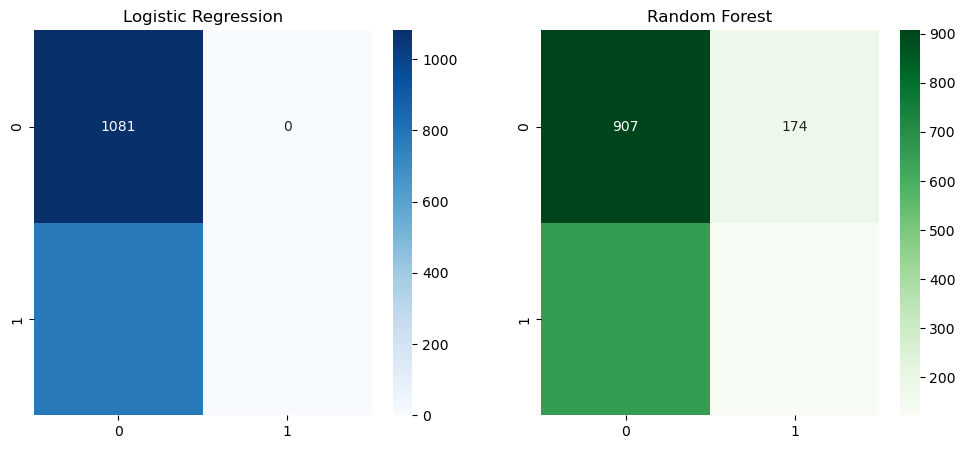

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions from best estimators
log_best_pred = log_grid.predict(X_test)
rf_best_pred = rf_grid.predict(X_test)

print("Tuned Logistic Regression Report:")
print(classification_report(y_test, log_best_pred))

print("Tuned Random Forest Report:")
print(classification_report(y_test, rf_best_pred))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, log_best_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression')

sns.heatmap(confusion_matrix(y_test, rf_best_pred), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest')

plt.show()


#### Final Model Selection & Prediction

In [13]:
# Assume Random Forest performed better
final_model = rf_grid.best_estimator_
final_model.fit(X_train, y_train)
final_predictions = final_model.predict(X_test)


#### Export Final Model

In [14]:
import joblib
joblib.dump(final_model, 'final_churn_model.pkl')
print("Model exported as final_churn_model.pkl")


Model exported as final_churn_model.pkl


#### Project Summary

- Two models were trained: Logistic Regression and Random Forest.

- Hyperparameter tuning was applied using GridSearchCV.

- Based on F1-score and recall, Random Forest performed better and was selected as the final model.

- The model was exported and is now ready for deployment or integration into an application.

- Key predictors of churn include engagement behavior and subscription type.
